# Exploratory work for the [IAFlash](https://entrepreneur-interet-general.etalab.gouv.fr/defis/2019/iaflash.html) challenge

## Example of API skeleton

This is in essence what a client API whould run, given an idoine model saved in `Intelligence`.  

### Imports

In [1]:
import os
HOME = os.path.expanduser('~/')
HOST = os.uname()[1]
if HOST == 'Arthurs-MacBook-Pro.local':
    os.chdir(os.path.join(HOME, 'Documents/GitHub/EIG3_IAFlash/'))    # @home
else:
    raise ValueError('unknown host: {}'.format(HOST))
    
import numpy as np
import time
import pickle
from PIL import Image

import matplotlib.pyplot as plt
%matplotlib inline

from keras.models import load_model

/Users/arthur/anaconda3/envs/tree/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


### Variables

In [2]:
# data
if HOST == 'Arthurs-MacBook-Pro.local':
#     pathToDataDir = os.path.join(HOME, 'Documents/Dropbox/Transit/EIG3_IAFlash/Patches/edge128bwTrueresampleFilter0')
    pathToDataDir = os.path.join(HOME, 'Documents/Dropbox/Transit/EIG3_IAFlash/Patches/edge128bwFalseresampleFilter0') # (small) MobileNet
    pathToIntellDir = os.path.join(HOME, 'Documents/GitHub/EIG3_IAFlash/IAFlash/Intelligence/')
else:
    raise ValueError('unknown host: {}'.format(HOST))

# intelligence
datagen = pickle.load(open(pathToIntellDir+'datagen.pkl','rb'))
classesDict = pickle.load(open(pathToIntellDir+'classesDict.pkl','rb'))
model = load_model(pathToIntellDir+'model.h5')
K = 5

# testing
image_file = os.path.join(pathToDataDir, 'Test', 'Porsche Panamera Sedan 2012/014241.jpg')

# seed
seed = 8
np.random.seed(seed)

### Example of API call


top 5 predictions for image:


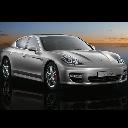

   Bentley Continental Supersports Conv. Convertible 2012 (0.027842506766319275)
   Bentley Mulsanne Sedan 2011 (0.025489442050457)
   Suzuki Aerio Sedan 2007 (0.01977318525314331)
   Ferrari 458 Italia Convertible 2012 (0.01694091036915779)
   Dodge Durango SUV 2007 (0.016813702881336212)

all predictions:


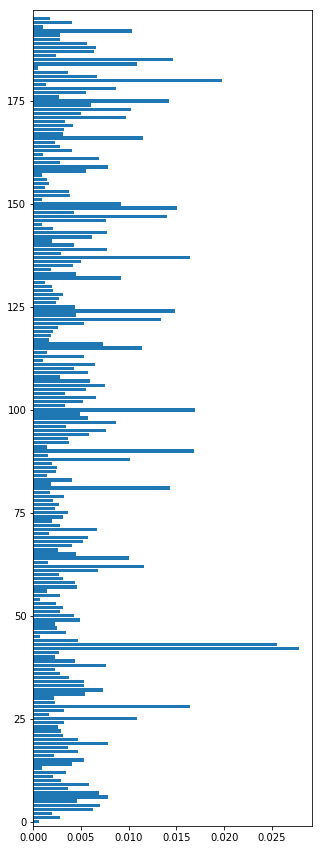

In [3]:
#-- load image and array
image = Image.open(image_file)

x = np.array(image)
if 'channels_last' == datagen.data_format:
    x = x.reshape((1,) + x.shape) # [sample, w, h, channel]
else:
    raise ValueError('cannot work with othet data format than "channels_last".')
    
    
#-- run model
# NB: we use a (dummy) generator in order to
# take into account the processing done by `datagen`
generator = datagen.flow(x,
                         y=None,
                         batch_size=1,
                         shuffle=False,
                         seed=None,
#                          save_to_dir=pathToDataDir, # use this to print one batch when calling generator[batchIdx]
#                          save_prefix='valid_',      #
#                          save_format='png'          #
                         )

score = model.predict_generator(generator,
                                steps=len(generator),
                                max_queue_size=10,
                                workers=1,
                                use_multiprocessing=False,
                                verbose=0).flatten()
predicted = np.argmax(score)
argsort_score = np.argsort(score)[::-1]


#-- output
print('\ntop {} predictions for image:'.format(K))
display(image)
for k in range(K):
    iv = int(argsort_score[k]) # NB: does not work inside the list comprehension...
    label = [k for k,v in classesDict.items() if v == iv][0]
    print('   {} ({})'.format(label, score[argsort_score[k]]))
    
print('\nall predictions:')
f = plt.figure(figsize=(5,15))
ax = f.add_subplot(1,1,1)
ax.barh(np.arange(len(score)),
        score,
        height=0.8,
        left=None,
        align='center')
ax.set_ylim((-1,len(score)+1))
plt.show()